در این قسمت کتاب خانه مربوط به معماری یونت را نصب می کنیم

In [1]:
!pip install segmentation-models
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user

     |████████████████████████████████| 50 kB 5.5 MB/s 


کتاب خانه های لازم را به کد اضافه می کنیم

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [3]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
import keras.utils
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [4]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [5]:
import os
from glob import glob
import scipy.io
import numpy as np
import cv2
import matplotlib.pyplot as plt

در این قسمت دیتا را لود می کنیم

In [6]:
st='/content/drive/MyDrive/CoNSeP/Train/Images/train_'

In [7]:
input_image=[]
for i in range(27):
    temp=np.resize(cv2.imread(st+str(i+1)+'.png'),(320,320,3))
    input_image.append(temp)

In [8]:
st='/content/drive/MyDrive/CoNSeP/Train/Labels/train_'

In [9]:
out_image=[]
for i in range(27):
    mats=scipy.io.loadmat(st+str(i+1)+'.mat')
    temp=np.resize(mats['type_map'],(320,320))
    out_image.append(temp)

از این تابع برای آگمت کردن دیتا استفاده می کنیم که به ازای هر عکس  سه عکس دریافت میکنم
شامل فلیپ کردن و روتیت  هر عکس

In [ ]:
import cv2 as cv
def data_agmenting(x_train, y_train):
  new_x_train = list()
  new_y_train = list()
  for i in range(27):
      new_x_train.append(cv2.rotate(x_train[i],cv.cv2.ROTATE_90_CLOCKWISE))
      new_y_train.append(cv2.rotate(y_train[i],cv.cv2.ROTATE_90_CLOCKWISE))
      new_x_train.append(cv2.flip(x_train[i],0))
      new_y_train.append(cv2.flip(y_train[i],0))
      new_x_train.append(cv2.flip(x_train[i],1))
      new_y_train.append(cv2.flip(y_train[i],1))
  return new_x_train, new_y_train

In [ ]:
new_x_train, new_y_train=data_agmenting(input_image,out_image)

In [10]:
i=input_image+new_x_train
o=out_image+new_y_train

In [11]:
x_train=np.array(i)
y_train=np.array(o)

چون که لیبل خروجی شامل 8 کلاس است نیاز داریم تا لیبل های خروجی را one hot کنیم

In [12]:
y_=to_categorical(y_train)

در این قسمت دیتا ولیدیشن و ترین را جدا میکنیم برای تنظیم هایپر پارامتر ها

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_, test_size=0.15,shuffle=False)

در اینجا مدل را می سازیم

In [14]:
BACKBONE = 'resnet152'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

In [15]:
model = sm.Unet(BACKBONE,input_shape=(320,320,3),classes=8,activation='softmax',encoder_weights='imagenet',encoder_freeze=True)

234340352/234326024 [==============================] - 9s 0us/step


In [16]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [17]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [18]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [19]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [20]:
model.compile(optim, total_loss, metrics)

In [ ]:
model.fit(x=X_train,
    y=Y_train,
    batch_size=2,
    epochs=30,
    validation_data=(X_val, Y_val),
)

Epoch 1/30
46/46 [==============================] - 79s 569ms/step - loss: 0.9714 - iou_score: 0.2121 - f1-score: 0.2194 - val_loss: 0.9465 - val_iou_score: 0.6599 - val_f1-score: 0.6767
Epoch 2/30
46/46 [==============================] - 21s 450ms/step - loss: 0.9405 - iou_score: 0.4357 - f1-score: 0.4518 - val_loss: 0.9408 - val_iou_score: 0.6692 - val_f1-score: 0.6880
Epoch 3/30
46/46 [==============================] - 21s 449ms/step - loss: 0.9215 - iou_score: 0.4989 - f1-score: 0.5198 - val_loss: 0.9229 - val_iou_score: 0.6914 - val_f1-score: 0.7099
Epoch 4/30
46/46 [==============================] - 21s 448ms/step - loss: 0.9089 - iou_score: 0.4934 - f1-score: 0.5119 - val_loss: 0.9122 - val_iou_score: 0.7128 - val_f1-score: 0.7253
Epoch 5/30
46/46 [==============================] - 21s 449ms/step - loss: 0.9002 - iou_score: 0.5235 - f1-score: 0.5385 - val_loss: 0.9111 - val_iou_score: 0.7055 - val_f1-score: 0.7168
Epoch 6/30
46/46 [==============================] - 21s 449ms/ste

In [21]:
st='/content/drive/MyDrive/CoNSeP/Test/Images/test_'

In [22]:
input_image=[]
for i in range(14):
    temp=np.resize(cv2.imread(st+str(i+1)+'.png'),(320,320,3))
    input_image.append(temp)

In [23]:
st='/content/drive/MyDrive/CoNSeP/Test/Labels/test_'

In [24]:
out_image=[]
for i in range(14):
    mats=scipy.io.loadmat(st+str(i+1)+'.mat')
    temp=np.resize(mats['type_map'],(320,320))
    out_image.append(temp)

In [25]:
x=np.array(input_image)
y=np.array(out_image)

In [26]:
_y=to_categorical(y)

In [ ]:
x_train.shape

(108, 320, 320, 3)

In [34]:
history=model.fit(x=x_train,
    y=y_,
    batch_size=2,
    epochs=20,
    validation_data=(x, _y),)


Epoch 1/20
14/14 [==============================] - 7s 476ms/step - loss: 0.8628 - iou_score: 0.4824 - f1-score: 0.5019 - val_loss: 0.8736 - val_iou_score: 0.4004 - val_f1-score: 0.4155
Epoch 2/20
14/14 [==============================] - 6s 454ms/step - loss: 0.8680 - iou_score: 0.4823 - f1-score: 0.5012 - val_loss: 0.8747 - val_iou_score: 0.4014 - val_f1-score: 0.4220
Epoch 3/20
14/14 [==============================] - 6s 469ms/step - loss: 0.8611 - iou_score: 0.4769 - f1-score: 0.4966 - val_loss: 0.8701 - val_iou_score: 0.4043 - val_f1-score: 0.4201
Epoch 4/20
14/14 [==============================] - 6s 470ms/step - loss: 0.8615 - iou_score: 0.4716 - f1-score: 0.4933 - val_loss: 0.8702 - val_iou_score: 0.4026 - val_f1-score: 0.4170
Epoch 5/20
14/14 [==============================] - 6s 469ms/step - loss: 0.8646 - iou_score: 0.4684 - f1-score: 0.4888 - val_loss: 0.8696 - val_iou_score: 0.4032 - val_f1-score: 0.4198
Epoch 6/20
14/14 [==============================] - 6s 469ms/step - lo

In [33]:
for l in model.layers:
  l.trainable = True

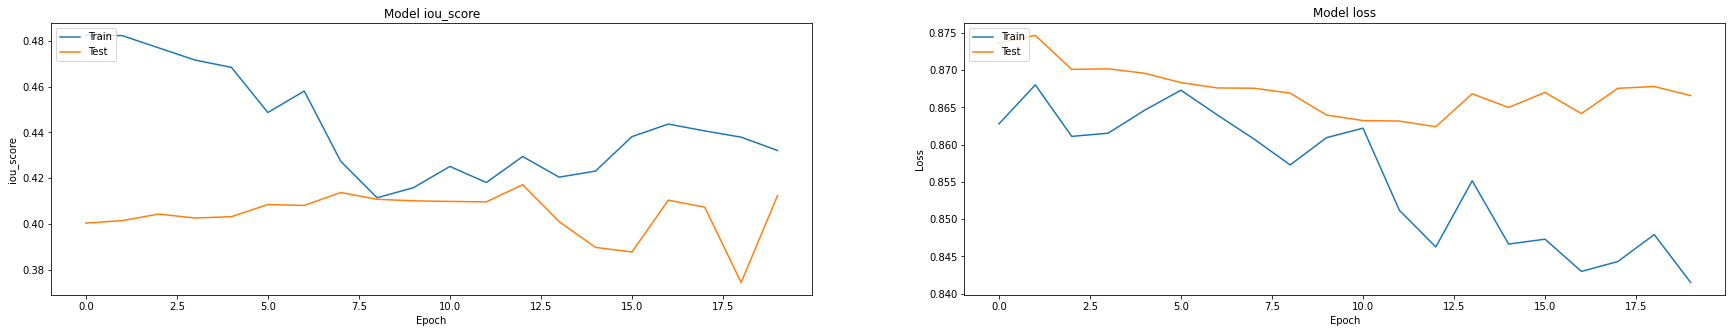

In [35]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
u=model.predict(x)
y_pred = np.argmax(u, axis=-1)

In [38]:
EPS=1e-12
def get_iou(gt, pr, n_classes):
    class_wise = np.zeros(n_classes)
    for cl in range(n_classes):
        intersection = np.sum((gt == cl)*(pr == cl))
        union = np.sum(np.maximum((gt == cl), (pr == cl)))
        iou = float(intersection)/(union + EPS)
        class_wise[cl] = iou
    return class_wise


In [39]:
all_iou = get_iou(y, y_pred, 8)

In [40]:
all_iou

array([8.19606682e-01, 0.00000000e+00, 6.08695652e-02, 3.38764863e-05,
       5.32683006e-02, 1.32112143e-01, 1.51041667e-03, 0.00000000e+00])

In [41]:
import sys
def get_dice(Y_test, Y_pred, num_class):

  total_dice = np.zeros((num_class,))

  for i in range(num_class):
    for j in range(Y_test.shape[0]):
      total_dice[i] += (2 * np.sum(Y_pred[j][Y_test[j] == i] == i)) / (np.sum(Y_pred[j] == i) + np.sum(Y_test[j] == i))
    if np.isnan(total_dice[i]):
      total_dice[i] = 0
  total_dice = (total_dice / Y_test.shape[0]).astype(float)

  return total_dice

In [42]:
all_dic=get_dice(y, y_pred, 8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


In [43]:
all_dic

array([0.89541033, 0.        , 0.10348327, 0.        , 0.04976073,
       0.20936416, 0.        , 0.        ])

In [44]:
h=y.reshape((14,-1))
h_pred=y_pred.reshape((14,-1))

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
sum=0

for i in range(14):
  sum=sum+accuracy_score(h[i], h_pred[i])

sum/14


0.7613434709821428

In [47]:
from sklearn.metrics import confusion_matrix
import itertools

total_cm = np.zeros((8,8)).astype(float)
for i in range(14):
  cm = confusion_matrix(y_true=h[i], y_pred=h_pred[i])
  for i in range(8):
    for j in range(8):
      try:
        total_cm[i][j] += cm[i][j]
      except:
        pass

total_cm = total_cm / 14
total_cm = total_cm.astype(float)
label_names = ['0', '1', '2', '3', '4', '5', '6', '7']

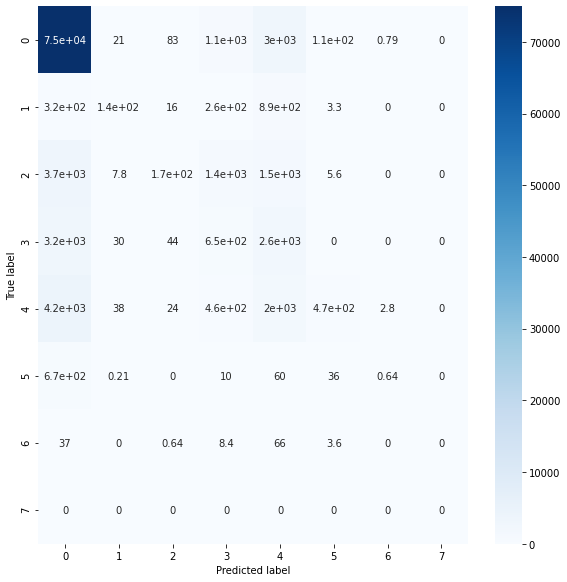

In [48]:
import seaborn as sns
labels=['0', '1', '2', '3', '4', '5', '6', '7']

figure = plt.figure(figsize=(8,8))
sns.heatmap(total_cm, annot=True,cmap=plt.cm.Blues, xticklabels=labels, yticklabels=labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()